In [1]:
import os
import random
import joblib             # pip install joblib (optional, used to save encoders)
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from lightfm import LightFM
from lightfm.data import Dataset


/Users/neelb94/Documents/DS_Projects/ml-100k/venv/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


### Load raw datasets and prepare as dataframes

In [2]:
data_source = 'full' # full or small

if data_source == 'small':
    root = "../data/raw/ml-latest-small/"
else:
    root = "../data/raw/ml-latest/"


In [3]:
ratings_df = pd.read_csv(f"{root}ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [4]:
movies_df = pd.read_csv(f"{root}movies.csv")
# Encode movie genres as features
movies_df['genres'] = movies_df['genres'].str.split('|')
#movie_genres = [(row['movieId'], row['genres']) for _, row in movies_df.iterrows()]



In [5]:
movies_df_long = movies_df[['movieId', 'genres']].explode('genres', ignore_index=True)

In [6]:
movies_df_long

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy
...,...,...
152283,288971,Horror
152284,288975,Documentary
152285,288977,Crime
152286,288977,Thriller


In [7]:
tags_df = pd.read_csv(f"{root}tags.csv")
tags_df.head()

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [8]:
tags_df = tags_df[['movieId', 'tag']]

In [9]:
tags_df["tag"] = (
    tags_df["tag"]
    .astype(str)
    .str.lower()
    .str.strip()
)


In [10]:
tags_df = tags_df.dropna(subset=["tag"])
tags_df = tags_df.drop_duplicates()


In [11]:
len(set(tags_df['tag']))

143264

In [12]:
# Rename columns to have the same name
df1 = tags_df.rename(columns={'tag': 'label'})
df2 = movies_df_long.rename(columns={'genres': 'label'})

# Concatenate them vertically
movie_full_df = pd.concat([df1, df2], ignore_index=True)

In [13]:
movie_full_df

,movieId,label
0,260,good vs evil
1,260,harrison ford
2,260,sci-fi
3,1221,al pacino
4,1221,mafia
...,...,...
1294901,288971,Horror
1294902,288975,Documentary
1294903,288977,Crime
1294904,288977,Thriller


In [14]:
print(movie_full_df.shape)
counts = movie_full_df['label'].value_counts()
common_labels = counts[counts > 100].index
movie_full_df = movie_full_df[movie_full_df['label'].isin(common_labels)]
print(movie_full_df.shape)

(1294906, 2)
(798606, 2)


In [15]:
movie_lists_df = (
    movie_full_df
    .groupby('movieId')['label']
    .apply(list)
    .reset_index()
)


In [16]:
# Initialize LightFM dataset
dataset = Dataset()

# Get unique users, items, and genres
unique_users = ratings_df['userId'].unique()
unique_movies = movies_df['movieId'].unique()
unique_tags = movie_full_df['label'].unique()

# Fit dataset schema
dataset.fit(
    users=unique_users,
    items=unique_movies,
    item_features=unique_tags
)


In [17]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)


In [ ]:
min_interactions = 5
user_counts = train_df['userId'].value_counts()
item_counts = train_df['movieId'].value_counts()

train_df = train_df[
    train_df['userId'].isin(user_counts[user_counts >= min_interactions].index) &
    train_df['movieId'].isin(item_counts[item_counts >= min_interactions].index)
]


In [18]:
train_interactions, _ = dataset.build_interactions(
    ((row['userId'], row['movieId'], row['rating']) for _, row in train_df.iterrows())
)

test_interactions, _ = dataset.build_interactions(
    ((row['userId'], row['movieId'], row['rating']) for _, row in test_df.iterrows())
)


In [19]:
item_features = dataset.build_item_features(
    ((row['movieId'], row['label']) for _, row in movie_lists_df.iterrows())
)


In [22]:
model = LightFM(loss='bpr', no_components=16, learning_rate=0.05)
model.fit(
    train_interactions,
    item_features=item_features,
    epochs=10,
    num_threads=4
)


In [ ]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# Compute metrics on test set
precision = precision_at_k(model, test_interactions, item_features=item_features, k=5).mean()
recall = recall_at_k(model, test_interactions, item_features=item_features, k=5).mean()
auc = auc_score(model, test_interactions, item_features=item_features).mean()

print(f'Precision@5: {precision:.3f}')
print(f'Recall@5: {recall:.3f}')
print(f'AUC: {auc:.3f}')


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

def evaluate_lightfm(model, train_interactions, test_interactions, item_features=None, max_k=20):
    """
    Evaluate a LightFM model and plot Precision@k and Recall@k curves.
    
    Parameters:
        model: trained LightFM model
        train_interactions: sparse matrix for training interactions
        test_interactions: sparse matrix for test interactions
        item_features: optional sparse matrix of item features
        max_k: maximum k for evaluation
    """
    ks = np.arange(1, max_k + 1)
    precisions = []
    recalls = []

    for k in ks:
        p = precision_at_k(model, test_interactions, train_interactions=train_interactions,
                           item_features=item_features, k=k).mean()
        r = recall_at_k(model, test_interactions, train_interactions=train_interactions,
                        item_features=item_features, k=k).mean()
        precisions.append(p)
        recalls.append(r)
    
    auc = auc_score(model, test_interactions, train_interactions=train_interactions,
                    item_features=item_features).mean()

    print(f"AUC: {auc:.3f}")

    # Plot Precision and Recall curves
    plt.figure(figsize=(10,5))
    plt.plot(ks, precisions, marker='o', label='Precision@k')
    plt.plot(ks, recalls, marker='x', label='Recall@k')
    plt.xlabel("k (top-k recommendations)")
    plt.ylabel("Score")
    plt.title("LightFM Evaluation")
    plt.xticks(ks)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return ks, precisions, recalls, auc


AUC: 0.938


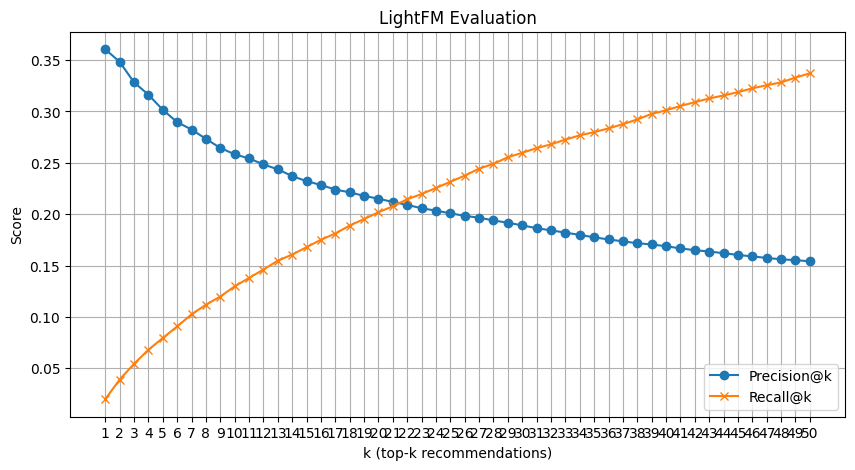

In [37]:
ks, precisions, recalls, auc = evaluate_lightfm(
    model,
    train_interactions=train_interactions,
    test_interactions=test_interactions,
    item_features=item_features,
    max_k=50
)
